---

**<h1><center>Análisis de la calidad de trozos de caña de azúcar mediante visión artificial</center></h1>**

**<h2><center> Visión Artificial - 2024-2</center></h2>**

<center><img src="unal.png" width="300"></center>

**<h3> Presentado por: </h3>**
<ul>
  <li>Juan Esteban Arango Zapata - <a href="mailto:juarangoz@unal.edu.co">juarangoz@unal.edu.co</a> - CC 1018230863</li>
  <li>Paulina Hernández Morales - <a href="mailto:pauhernandezmo@unal.edu.co">pauhernandezmo@unal.edu.co</a> - TI 1035420888</li>
  <li>Jimena Hernández Castillo - <a href="mailto:jihernandezc@unal.edu.co">jihernandezc@unal.edu.co</a> - TI 1022094340</li>
  <li>Juan Camilo López López - <a href="mailto:julopezlop@unal.edu.co">julopezlop@unal.edu.co</a> - CC 1025533050</li>
</ul>

---

**<h3><center> Modelo de clasificación de cañas </h3></center>**

**<h4>Importación de librerias:</h4>**

In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

**<h4>Aumento de imágenes:</h4>**

Uno de los mayores desafíos en la construcción de modelos clasificadores es contar con un dataset balanceado y representativo. En nuestro caso, la cantidad de imágenes disponibles es limitada, lo que podría afectar el rendimiento del modelo. Para abordar este problema, aplicamos técnicas de aumento de datos como:  
 
- **Rotación, traslación y escalado**, para mejorar la capacidad del modelo de reconocer variaciones en la orientación y posición.  
- **Reflejos y deformaciones**, que introducen variabilidad sin alterar la naturaleza de la caña de azúcar.  
- **Zoom aleatorio**, que ayuda a la generalización del modelo al entrenarlo en diferentes niveles de detalle. 

In [2]:
# Crear un directorio para guardar las imágenes aumentadas
augmented_dir = 'data/augmented'
os.makedirs(augmented_dir, exist_ok=True)

# Configurar el generador de aumento de datos
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Función para guardar imágenes aumentadas
def save_augmented_images(images, label, prefix, num_augmented):
    for i, img in enumerate(images):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir a RGB
        img = cv2.resize(img, (224, 224))  # Redimensionar
        img = np.expand_dims(img, axis=0)  # Agregar batch dimension
        j = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_image = batch[0]
            augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)  # Convertir de nuevo a BGR
            cv2.imwrite(os.path.join(augmented_dir, f'{prefix}_{i}_{j}.jpg'), augmented_image)
            j += 1
            if j >= num_augmented:
                break

# Cargar imágenes originales
healthy = [cv2.imread(f'data/healthy/healthy{i}.jpg') for i in range(1, 22)]
damaged = [cv2.imread(f'data/damaged/damaged{i}.jpg') for i in range(1, 20)]
mutilated = [cv2.imread(f'data/mutilated/mutilated{i}.jpg') for i in range(1, 19)]

# Guardar imágenes aumentadas
save_augmented_images(healthy, 'healthy', 'healthy', 142)
save_augmented_images(damaged, 'damaged', 'damaged', 156)
save_augmented_images(mutilated, 'mutilated', 'mutilated', 165)

print("Imágenes aumentadas generadas y guardadas en el directorio 'data/augmented'.")

Imágenes aumentadas generadas y guardadas en el directorio 'data/augmented'.


**<h4>Carga y preprocesamiento de imágenes:</h4>**

Con las imágenes aumentadas, procedimos a cargarlas, normalizarlas y dividirlas en conjuntos de entrenamiento y prueba:

In [3]:
# Función para cargar imágenes y etiquetas
def load_images_and_labels(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Redimensionar las imágenes
            images.append(img)
            if 'healthy' in filename:
                labels.append(0)
            elif 'damaged' in filename:
                labels.append(1)
            elif 'mutilated' in filename:
                labels.append(2)
    return np.array(images), np.array(labels)

# Cargar imágenes y etiquetas
images, labels = load_images_and_labels('data/augmented')

# Normalizar las imágenes
images = images.astype('float32') / 255.0

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Convertir etiquetas a one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

**<h4>Entrenamiento del modelo:</h4>**

Para clasificar los trozos de caña de azúcar, teníamos el problema de contar con muy pocas imágenes, lo que dificultaba entrenar un modelo desde cero sin caer en sobreajuste. Es por esto, que luego de probar múltiples estrategias para mejorar la segmentación de imágenes antes del entrenamiento del modelo, la mejor estrategia consistió en usar un modelo basado en **MobileNetV2**.

MobileNetV2 es una red neuronal convolucional preentrenada, por lo que ya tiene conocimiento sobre miles de imágenes, así que solo tuvimos que afinar las últimas capas para que aprendiera a distinguir los tipos de caña. Además, no requiere demasiada potencia de procesamiento, y gracias a su arquitectura optimizada y el uso de **transfer learning**, pudimos obtener buenos resultados sin un dataset masivo.

Dentro de las pruebas que realizamos, para solucionar el problema de sobreajuste que se estaba generando por la poca cantidad de imágenes, además de implementar el aumento de datos, congelamos las capas iniciales del modelo y solo entrenamos las finales, reduciendo el riesgo de que aprendiera demasiado los detalles específicos de nuestro pequeño conjunto de datos.  

In [5]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Congelar las capas del modelo base
base_model.trainable = False

# Definir el modelo completo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
223/223 [==============================] - 22s 89ms/step - loss: 0.6693 - accuracy: 0.7189 - val_loss: 0.3236 - val_accuracy: 0.8868
Epoch 2/20
223/223 [==============================] - 19s 84ms/step - loss: 0.3448 - accuracy: 0.8676 - val_loss: 0.2156 - val_accuracy: 0.9249
Epoch 3/20
223/223 [==============================] - 19s 87ms/step - loss: 0.2528 - accuracy: 0.9054 - val_loss: 0.1667 - val_accuracy: 0.9462
Epoch 4/20
223/223 [==============================] - 19s 86ms/step - loss: 0.1892 - accuracy: 0.9379 - val_loss: 0.1316 - val_accuracy: 0.9580
Epoch 5/20
223/223 [==============================] - 20s 88ms/step - loss: 0.1535 - accuracy: 0.9485 - val_loss: 0.1078 - val_accuracy: 0.9692
Epoch 6/20
223/223 [==============================] - 19s 85ms/step - loss: 0.1298 - accuracy: 0.9567 - val_loss: 0.0915 - val_accuracy: 0.9753
Epoch 7/20
223/223 [==============================] - 20s 88ms/step - loss: 0.1065 - accuracy: 0.9656 - val_loss: 0.0820 - val_accuracy:

**<h4>Evaluación del modelo:</h4>**

Para evaluar nuestro modelo, utilizamos el conjunto de prueba y calculamos su precisión. Además, generamos una matriz de confusión para visualizar cómo clasifica los diferentes tipos de caña de azúcar (sana, dañada y mutilada), identificando posibles errores y patrones de confusión entre clases.

56/56 [==============================] - 4s 70ms/step - loss: 0.0259 - accuracy: 0.9933
Test accuracy: 0.9933
56/56 [==============================] - 4s 67ms/step


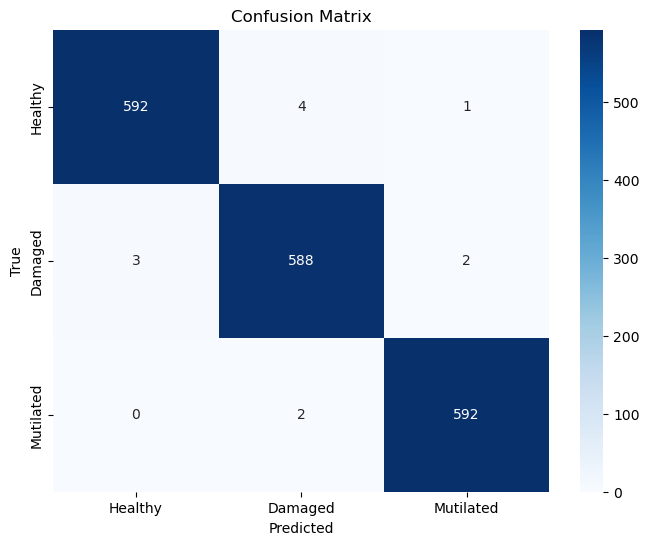

In [11]:
# Evaluar el modelo
_, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy:.4f}')

# Generar predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Crear y graficar la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Damaged', 'Mutilated'], 
            yticklabels=['Healthy', 'Damaged', 'Mutilated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Guardar el modelo en un archivo
model.save('cane_classifier_model.h5')

Para probar qué tan bien nuestro modelo clasifica imágenes fuera del conjunto de entrenamiento, realizamos una prueba con imágenes aleatorias de cada categoría (sana, dañada y mutilada), y visualizamos los resultados para identificar posibles errores y áreas de mejora.

1/1 [==============================] - 0s 28ms/step


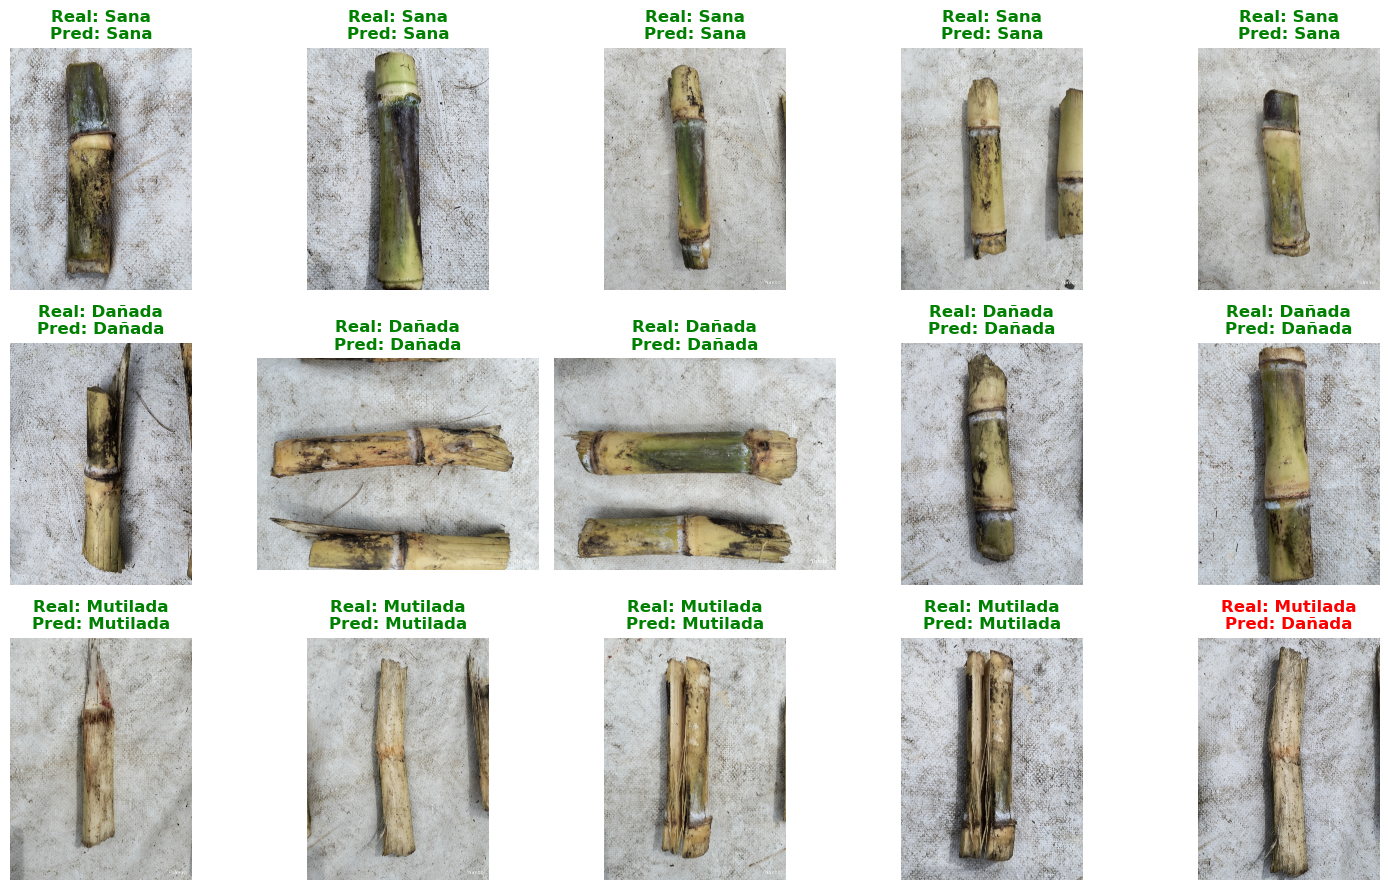

In [16]:
# Cargar el modelo
model = tf.keras.models.load_model('cane_classifier_model.h5')

# Definir las etiquetas de las clases
class_labels = {0: "Sana", 1: "Dañada", 2: "Mutilada"}

# Función para preprocesar imagen
def preprocess_image(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB
    img = cv2.resize(img, (128, 128))  # Redimensionar al tamaño esperado por el modelo
    img = img.astype(np.float32) / 255.0  # Normalizar y convertir a float32
    img = np.expand_dims(img, axis=0)  # Agregar batch dimension
    return img

# Función para cargar imágenes aleatorias de una carpeta
def load_random_images(folder, num_samples=5):
    images = []
    filenames = os.listdir(folder)
    selected_files = random.sample(filenames, min(num_samples, len(filenames)))  # Seleccionar aleatoriamente
    for file in selected_files:
        img = cv2.imread(os.path.join(folder, file))
        if img is not None:
            images.append(img)
    return images

# Cargar imágenes aleatorias de cada categoría
healthy_images = load_random_images('data/healthy', 5)
damaged_images = load_random_images('data/damaged', 5)
mutilated_images = load_random_images('data/mutilated', 5)

# Unir todas las imágenes en una lista para procesamiento
test_images = [(img, "Sana") for img in healthy_images] + \
              [(img, "Dañada") for img in damaged_images] + \
              [(img, "Mutilada") for img in mutilated_images]

# Crear la figura con 3 filas y el número de imágenes por fila
num_cols = max(len(healthy_images), len(damaged_images), len(mutilated_images))
fig, axes = plt.subplots(3, num_cols, figsize=(num_cols * 3, 9))

# Asegurar que `axes` siempre sea un array bidimensional
if num_cols == 1:
    axes = np.expand_dims(axes, axis=1)

# Realizar predicciones y mostrar resultados
for row, category in enumerate(["Sana", "Dañada", "Mutilada"]):
    category_images = [img for img, label in test_images if label == category]
    
    for col in range(num_cols):
        if col < len(category_images):
            image = category_images[col]
            img_preprocessed = preprocess_image(image)
            prediction = model.predict(img_preprocessed)
            predicted_class = np.argmax(prediction)
            predicted_label = class_labels[predicted_class]

            # Determinar si la predicción es correcta
            correct = (category == predicted_label)
            title_color = "green" if correct else "red"  # Títulos en verde si es correcto, rojo si es incorrecto

            # Mostrar la imagen con borde de color
            axes[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axes[row, col].set_title(f'Real: {category}\nPred: {predicted_label}', 
                                     fontsize=12, fontweight='bold', color=title_color)
        else:
            axes[row, col].axis('off')  # Apagar el eje si no hay imagen
        axes[row, col].axis('off')

# Ajustar el layout para mejorar visualización
plt.tight_layout()
plt.show()

De la evaluación del modelo realizada con la matriz de confusión, y la prueba con imágenes aleatorias, se concluye que el modelo es capaz de clasificar correctamente la mayoría de las imágenes, aunque presenta ciertas dificultades con imágenes que contienen trozos de caña mutilados, debido a la similitud de estos con los trozos dañados.